## 0. Packages and Dataloading

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
from IPython.display import Image, display, display, clear_output
import ipywidgets as widgets
from pathlib import Path
from glob import glob
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import sklearn
import h5py
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.curation as sc
import spikeinterface.widgets as sw



import bombcell as bc

import warnings
warnings.filterwarnings("ignore")


# sys.path.append("/home/ehefti/Github/DPQC")
sys.path.append("C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC")
import MaxTwo_Spikesorting.scripts.spike_sorting as ss
import MaxTwo_Activity_Screening.screen_maxtwo_activity as sma

## 1. Recording Overview

Found 24 wells in D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/data.raw.h5
Analyzing 10 seconds from each well for a rough overview.


Processing Wells:   0%|          | 0/24 [00:00<?, ?it/s]

**********
Maxwell file format is based on HDF5.
The internal compression requires a custom plugin!!!
This is a big pain for the end user.
You, as a end user, should ask Maxwell company to change this.
Please visit this page and install the missing decompression libraries:
https://share.mxwbio.com/d/4742248b2e674a85be97/
Then, link the decompression library by setting the `HDF5_PLUGIN_PATH` to your
installation location, e.g. via
os.environ['HDF5_PLUGIN_PATH'] = '/path/to/custom/hdf5/plugin/'

Alternatively, you can use the auto_install_maxwell_hdf5_compression_plugin() below
function that do it automagically.

**********
  Error processing well well000: Can't synchronously read data (can't open directory). Skipping this well.
**********
Maxwell file format is based on HDF5.
The internal compression requires a custom plugin!!!
This is a big pain for the end user.
You, as a end user, should ask Maxwell company to change this.
Please visit this page and install the missing decompression 

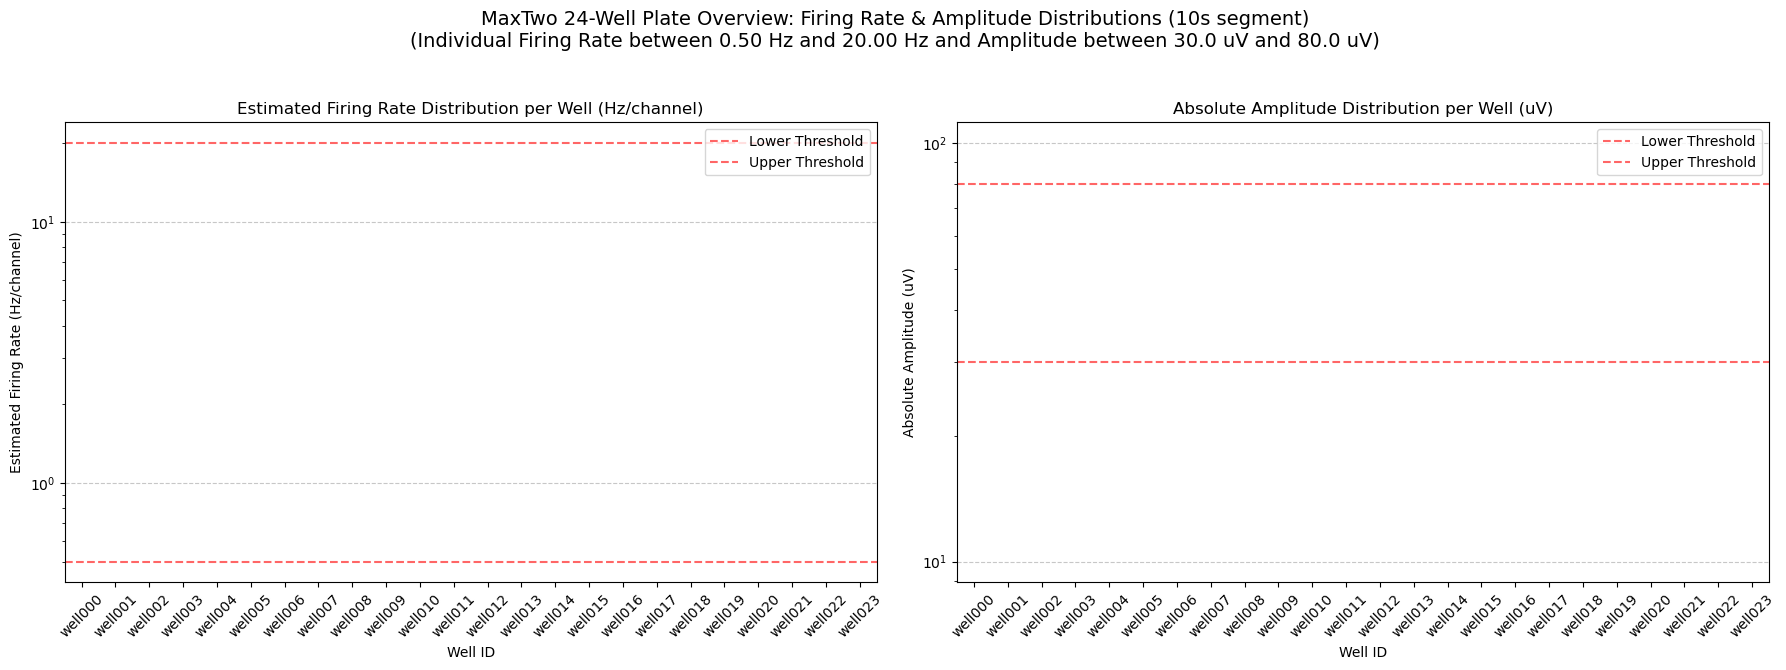

In [19]:
#rec_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
rec_path = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/data.raw.h5"
df_summary, rate_dist, amp_dist = sma.screen_maxtwo_activity(rec_path, segment_duration_s=10,
                                                             rate_lower_threshold = 0.5,
                                                             rate_upper_threshold = 20,
                                                             amp_lower_threshold = 30,
                                                             amp_upper_threshold = 80)



#log scale

## 2. Spikesorting
_This part of the pipeline is computationally heavy. It is advisable to run this on a GPU or Cluster._

In [4]:
# Choose sorter and set parameters
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/Kilosort')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)

sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5 #6 als Standardwert
sorter_params['minFR'] = 0.01 #Lower value -> less units that get automatically deleted
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
sorter_params['NT'] = 64*1024 + 64 #Batch size -> Wieviel wird auf einmal angeschaut


# Set your paths
# Linux: '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/.../data.raw.h5' 
# Windows: 'S:/group/hierlemann02/recordings/Maxtwo/.../data.raw.h5'
"""
rec_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
save_root = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/EI_iNeurons/241218/T002523/Network/'
"""
rec_path = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/data.raw.h5"
save_root = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/"

h5 = h5py.File(rec_path)
stream_ids = list(h5['wells'].keys())
stream_ids = stream_ids[0:24]

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: C:\Users\elias\OneDrive - ETH Zurich\2025FS - Master Thesis\1 - Scripts\Github\Kilosort


In [ ]:
for stream_id in tqdm(stream_ids):
    h5 = h5py.File(rec_path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(rec_path, stream_id=stream_id, rec_name=rec_name)
    ss.clean_sorting(rec, save_root, stream_id=stream_id, sorter=sorter, sorter_params=sorter_params, clear_files=True)

## 3. Qualitycontrol (Bombcell & SI-Model)

### 3.1 Bombcell

In [13]:
# Replace with your kilosort directory
well_id = 'well010'
ks_dir = 'D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/' #Path(save_root) / well_id / 'sorter_output'

# Set bombcell's output directory
save_path = Path(ks_dir) / "bc_output_test"
if not save_path.exists():
    save_path.mkdir(parents=True, exist_ok=True)

print(f"Using kilosort directory: {ks_dir}")

param = bc.get_default_parameters(ks_dir, kilosort_version=2)

# Modify some parameters
param['ephys_sample_rate'] = 10000  # Sample rate in Hz

h5 = h5py.File(rec_path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec = si.MaxwellRecordingExtractor(rec_path, stream_id=well_id, rec_name=rec_name)

param['nChannels'] = rec.get_num_channels()
param['raw_data_file'] = Path(ks_dir) / "recording.dat"
param['ephysKilosortPath']

pprint(param)

(quality_metrics, param, unit_type, unit_type_string) = bc.run_bombcell(ks_dir, save_path, param)

Using kilosort directory: D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 1e-05,
 'ephysKilosortPath': 'D:/Master '
                      'Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/',
 'ephys_meta_file': None,
 'ephys_sample_rate': 10000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin': 20,
 'keep_only_somatic': True,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'min

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'D:\\Master Thesis\\Data\\EI_iNeurons\\241218\\T002523\\Network\\well000\\sorter_output\\recording.dat'

See the metrics and the classification

In [ ]:
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

Take a look at your units in a GUI. Potentially adjust thresholds or change the classification:

In [ ]:
gui = bc.unit_quality_gui(
    ks_dir=ks_dir,
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=save_path,
)

#### Bombcell Philipp

In [43]:
from mxw_bombcell.generate_sorting_path_list import generate_sorting_path_list
from mxw_bombcell.infer_sampling_rate import infer_sampling_rate
from mxw_bombcell.bombcell_to_phy import bombcell_to_phy


# Suppress all warnings
warnings.filterwarnings('ignore')

qc_root_path = 'D:/Master Thesis/Data/EI_iNeurons'
path_logic = ['24*', 'T002523', 'Network', 'well*', 'sorter_output']

sorting_path_list = generate_sorting_path_list(qc_root_path, path_logic)
print(f"Found {len(sorting_path_list)} sortings")

# PARAMS
rerun = 1  # 1 to re-run, 0 to skip if metrics are present
gain_to_uV = 6.2
verbose = 0

for i, sorting_path in enumerate(sorting_path_list):
    ephysKilosortPath = sorting_path
    sampling_rate = infer_sampling_rate(ephysKilosortPath)
    
    kilosortVersion = 2 # Change if using Kilosort4
    savePath = os.path.join(ephysKilosortPath, "bc_output")

    param = bc.get_default_parameters(kilosort_path=ephysKilosortPath, kilosort_version=kilosortVersion, gain_to_uV=gain_to_uV)

    param['extractRaw'] = 0
    param['ephys_sample_rate'] = sampling_rate

    param['nSyncChannels'] = 0
    param['removeDuplicateSpikes'] = 0
    param['minWvDuration'] = 200
    param['maxWvDuration'] = 1500
    param['tauR_valuesMin'] = 0.001
    param['tauR_valuesMax'] = 0.003
    param['maxRPVviolations'] = 0.05
    param['verbose'] = verbose
    param['computeDistanceMetrics'] = 1

    qMetricsExist = (len(glob(os.path.join(savePath, 'qMetric*.mat'))) > 0) or \
                    (os.path.exists(os.path.join(savePath, 'templates._bc_qMetrics.parquet')))

    if not qMetricsExist or rerun:
        spikeTimes_samples, spikeTemplates, templateWaveforms, templateAmplitudes, pcFeatures, \
        pcFeatureIdx, channelPositions = bc.load_ephys_data(ephysKilosortPath)
        
        if len(spikeTimes_samples) > 0 and param['ephys_sample_rate'] > 0:
            param['minNumSpikes'] = round(np.max(spikeTimes_samples) / param['ephys_sample_rate'] / 20)
        else:
            param['minNumSpikes'] = 0

        param['nChannels'] = channelPositions.shape[0] if channelPositions is not None else 0





        (
            qMetrics,
            param,
            unitType,
            unitTypeString,
        ) = bc.run_bombcell(
            ephysKilosortPath, savePath, param
        )


        """
        qMetric, runtimes = bc.get_all_quality_metrics(param=param, 
                                                       unique_templates=None,
                                                       spike_times_seconds=spikeTimes_samples, 
                                                       spike_clusters=spikeTemplates, 
                                                       template_waveforms=templateWaveforms, 
                                                       template_amplitudes=templateAmplitudes,
                                                       time_chunks=None,
                                                       pc_features=pcFeatures, 
                                                       pc_features_idx=pcFeatureIdx,
                                                       channel_positions=channelPositions, 
                                                       save_path=savePath)
        
        unitType, unitTypeString = bc.get_quality_unit_type(param, qMetric)
        """


bc_path_list = [os.path.join(sp, "bc_output") for sp in sorting_path_list]

overwrite = True
bombcell_to_phy(bc_path_list[:3], overwrite)

Found 24 sortings


ValueError: All-NaN slice encountered

### 3.2 SI-Model

#### Train Model
You can train your own Model if you want - this is not necessary though. There is a model that works reasonably well for MaxTwo EPhys data. If you train your own model it might be more precise for your cell-line, but it takes a while to label your units manually and train the model to get reasonable results. The pretrained Model will be loaded in the next step of the pipeline, you can jump to "Apply Model".

##### Manual Labeling
In order to label your units manually and train your model, download phy and follow the instructions on the following GitHub repository: `https://github.com/cortex-lab/phy/`

The documentation to explain the GUI can be found here `https://phy.readthedocs.io/en/latest/`

You can also start the GUI from python, but you will have to change the kernel which makes you loose your cached variables. Use the code below:



```python
from phy.apps.template import template_gui
from pathlib import Path

save_root = 'your/path/to/your/sorted/wells/'
well_id = 'well010'
params_path = Path(save_root) / well_id / 'sorter_output' / 'params.py'
template_gui(params_path)
```

##### Training your Model

estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/30 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/30 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/30 [00:00<?, ?it/s]

"\n#labels = pd.read_csv(path_to_sorting / 'cluster_KSLabel.tsv', sep='\t')\n# manual_labels = ['good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad']\nmanual_labels = []\nfor i in range(len_1):\n    manual_labels.append('good')\nfor i in range(len_2):\n    manual_labels.append('bad')\n"

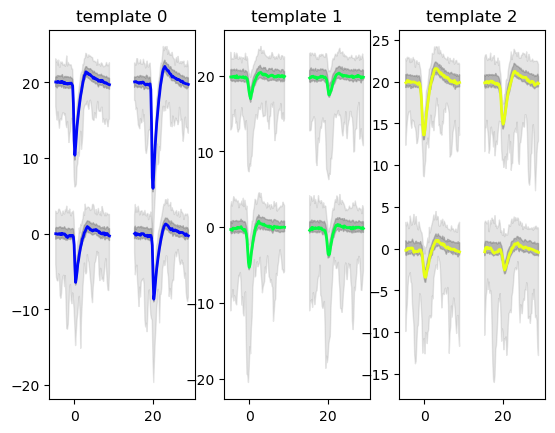

In [3]:
# Note, you can set the number of cores you use using e.g.
# si.set_global_job_kwargs(n_jobs = 8)

"""
os.environ['HDF5_PLUGIN_PATH'] = 'C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC/MaxTwo_Quality_Control/'

# Choose sorting to train the model on
well_id = 'well001'
path_to_sorting = Path(save_root) / well_id / 'sorter_output'
sorting_train = si.read_kilosort(folder_path=path_to_sorting)

# Real Recording Loading
h5 = h5py.File(rec_path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec_train = si.MaxwellRecordingExtractor(rec_path, stream_id=well_id, rec_name=rec_name)
"""

# For testing purposes
len_1 = 15
len_2 = 15
rec_train, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=1, num_units=len_1)
_, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=2, num_units=len_2)

sorting_train = si.aggregate_units([sorting_1, sorting_2])



analyzer = si.create_sorting_analyzer(sorting=sorting_train, recording=rec_train)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates'])
si.plot_unit_templates(analyzer, unit_ids=["0", "1", "2"])

analyzer.compute(['spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])


"""
label_path = Path(save_root) / well_id / 'sorter_output' / 'cluster_bc_unitType.tsv'
df = pd.read_csv(label_path, sep='\t')
manual_labels = ['good' if unit_type == 'GOOD' else 'bad' for unit_type in df['bc_unitType']]
"""


"""
#labels = pd.read_csv(path_to_sorting / 'cluster_KSLabel.tsv', sep='\t')
# manual_labels = ['good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad']
manual_labels = []
for i in range(len_1):
    manual_labels.append('good')
for i in range(len_2):
    manual_labels.append('bad')
"""

In [66]:
from spikeinterface.extractors.toy_example import generate_ground_truth_recording

# --- Define Output Directory for Labels ---
# IMPORTANT: Change this to your desired output directory, e.g., your sorter_output folder.
# This path should exist or be created before exporting.
# output_dir_for_labels = path_to_sorting # Change if needed

output_dir_for_labels = 'KiloSort_Quality_Control/'


# --- Load Your SpikeInterface Data ---
# Ensure rec_train, sorting_train, and analyzer are defined BEFORE this cell runs.
# If not, toy data will be generated for demonstration purposes.
if 'rec_train' not in locals() or 'sorting_train' not in locals() or 'analyzer' not in locals():
    print("WARNING: rec_train, sorting_train, or analyzer not defined. Generating toy data.")
    
    recording = generate_ground_truth_recording(
        durations=[10], sampling_frequency=30000, num_channels=4, seed=42
    )
    from spikeinterface.sorting_tools import NumpySorting
    spike_times = np.array([1000, 1050, 2000, 2050, 3000, 3050, 4000, 4050])
    spike_clusters = np.array([0, 0, 1, 1, 2, 2, 3, 3])
    sorting = NumpySorting.from_times_labels(spike_times, spike_clusters, sampling_frequency=recording.sampling_frequency)
    
    import tempfile
    temp_waveforms_folder = Path(tempfile.mkdtemp())
    analyzer = si.create_sorting_analyzer(sorting, recording, folder=temp_waveforms_folder, format="binary", sparse=False)
    analyzer.compute("random_spikes")
    analyzer.compute("unit_waveforms")
    analyzer.compute("correlograms")
    print(f"Loaded {len(sorting.get_unit_ids())} units from toy data.")
else:
    recording = rec_train
    sorting = sorting_train
    print(f"Using pre-defined rec_train, sorting_train, and analyzer. Loaded {len(sorting.get_unit_ids())} units.")

# --- Initialize Unit Properties for Labeling ---
unit_ids = sorting.get_unit_ids()
initial_labels = ['unlabeled'] * len(unit_ids)
sorting.set_property('quality_label', initial_labels)

current_unit_labels = {unit_id: 'unlabeled' for unit_id in unit_ids}
for i, unit_id in enumerate(unit_ids):
    current_unit_labels[unit_id] = sorting.get_property('quality_label')[i]

# --- Create Interactive Widgets ---
unit_selector = widgets.Dropdown(
    options=unit_ids,
    value=unit_ids[0],
    description='Select Unit:',
    disabled=False,
)

output_plot = widgets.Output()

button_good = widgets.Button(description="Label as Good", button_style='success')
button_mua = widgets.Button(description="Label as MUA", button_style='warning')
button_noise = widgets.Button(description="Label as Noise", button_style='danger')
button_unlabeled = widgets.Button(description="Unlabel", button_style='info')
button_export = widgets.Button(description="Export Labels to TSV", button_style='primary') # New button

label_status = widgets.Textarea(
    value='Labels will appear here.',
    description='Unit Labels:',
    disabled=True,
    layout=widgets.Layout(width='auto', height='150px')
)

# --- Define Update and Labeling Functions ---
def update_plot(change):
    selected_unit_id = change['new']
    with output_plot:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sw.plot_unit_waveforms(analyzer, unit_ids=[selected_unit_id], ax=axes[0], same_axis=True)
        axes[0].set_title(f"Waveforms for Unit {selected_unit_id} (Label: {current_unit_labels[selected_unit_id]})")

        sw.plot_autocorrelograms(analyzer, unit_ids=[selected_unit_id], ax=axes[1])
        axes[1].set_title(f"Autocorrelogram for Unit {selected_unit_id}")
        
        plt.tight_layout()
        plt.show()

def update_label_status():
    sorted_labels = current_unit_labels.items()
    label_text = "\n".join([f"Unit {uid}: {label}" for uid, label in sorted_labels])
    label_status.value = label_text

def apply_label(b):
    selected_unit_id = unit_selector.value
    label = b.description.split(" ")[2].lower()
    if label == "unlabel":
        label = "unlabeled"

    current_unit_labels[selected_unit_id] = label
    idx = np.where(unit_ids == selected_unit_id)[0][0] 
    new_property_values = list(sorting.get_property('quality_label'))
    new_property_values[idx] = label
    sorting.set_property('quality_label', new_property_values)

    with output_plot:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sw.plot_unit_waveforms(analyzer, unit_ids=[selected_unit_id], ax=axes[0], same_axis=True)
        axes[0].set_title(f"Waveforms for Unit {selected_unit_id} (Label: {current_unit_labels[selected_unit_id]})")

        sw.plot_autocorrelograms(analyzer, unit_ids=[selected_unit_id], ax=axes[1])
        axes[1].set_title(f"Autocorrelogram for Unit {selected_unit_id}")

        plt.tight_layout()
        plt.show()
    update_label_status()
    print(f"Unit {selected_unit_id} labeled as '{label}'")

    # --- Go to next unit automatically ---
    current_unit_index = list(unit_ids).index(selected_unit_id)
    next_unit_index = current_unit_index + 1

    if next_unit_index < len(unit_ids):
        unit_selector.value = unit_ids[next_unit_index]
    else:
        print("All units reviewed!")
        # Optionally, you could reset to the first unit or disable the selector
        # unit_selector.value = unit_ids[0]
        # unit_selector.disabled = True

def export_labels_to_tsv(b):
    """Exports the current unit labels to a TSV file."""
    labels_df = pd.DataFrame({
        'unit_id': list(current_unit_labels.keys()),
        'quality_label': list(current_unit_labels.values())
    })
    output_filepath = Path(output_dir_for_labels) / "manual_unit_labels.tsv"
    labels_df.to_csv(output_filepath, sep='\t', index=False)
    print(f"Labels exported to: {output_filepath}")

# --- Connect Widgets to Functions ---
unit_selector.observe(update_plot, names='value')

button_good.on_click(apply_label)
button_mua.on_click(apply_label)
button_noise.on_click(apply_label)
button_unlabeled.on_click(apply_label)
button_export.on_click(export_labels_to_tsv) # Connect the new button

# Initial plot and label status update
update_plot({'new': unit_selector.value})
update_label_status()

# --- Arrange and Display Widgets ---
label_buttons = widgets.HBox([button_good, button_mua, button_noise, button_unlabeled])
export_button_box = widgets.HBox([button_export])
ui = widgets.VBox([unit_selector, label_buttons, output_plot, label_status, export_button_box])

print("Displaying interactive GUI...")
display(ui)

# Example to access labeled data:
# good_units = [uid for uid, label in current_unit_labels.items() if label == 'good']
# print("\nExample: Good units after labeling:", good_units)

Using pre-defined rec_train, sorting_train, and analyzer. Loaded 30 units.


Displaying interactive GUI...


In [51]:
manual_labels = pd.read_csv(Path(output_dir_for_labels) / "manual_unit_labels.tsv", sep='\t')
print(manual_labels['quality_label'].to_list())

['good', 'good', 'good', 'good', 'good', 'good', 'noise', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise']


In [58]:
model_folder = "models/"
manual_labels = pd.read_csv(Path(output_dir_for_labels) / "manual_unit_labels.tsv", sep='\t')
manual_labels = manual_labels['quality_label'].tolist()

trainer = sc.train_model(
    mode="analyzers",
    labels=[manual_labels],
    analyzers=[analyzer],
    folder=model_folder,
    overwrite=True, # Set to True if you want to overwrite existing models
    metric_names = None, # Specify which metrics to use for training: by default uses those already calculted
    imputation_strategies = ["median"], # Defaults to all
    scaling_techniques = ["standard_scaler"], # Defaults to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier","LogisticRegression","MLPClassifier"]
    search_kwargs = {'cv': 3} # Parameters used during the model hyperparameter search
)

best_model = trainer.best_pipeline

accuracies = pd.read_csv(Path(model_folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

Running RandomForestClassifier with imputation median and scaling StandardScaler()
BayesSearchCV from scikit-optimize not available, using RandomizedSearchCV


,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),1.0,1.0,1.0,0,"{'n_estimators': 100, 'min_samples_split': 2, ..."


   prediction  probability
0        good     1.000000
1        good     0.880000
2        good     1.000000
3        good     1.000000
4        good     1.000000
5        good     0.980000
6       noise     1.000000
7        good     1.000000
8        good     1.000000
9        good     0.980000
10       good     1.000000
11       good     1.000000
12       good     0.980000
13       good     1.000000
14       good     0.927860
15      noise     1.000000
16      noise     0.990000
17      noise     1.000000
18      noise     1.000000
19      noise     0.970000
20      noise     0.970000
21      noise     0.992973
22      noise     1.000000
23      noise     0.989167
24      noise     0.989167
25      noise     1.000000
26      noise     0.960000
27      noise     1.000000
28      noise     0.970000
29      noise     1.000000


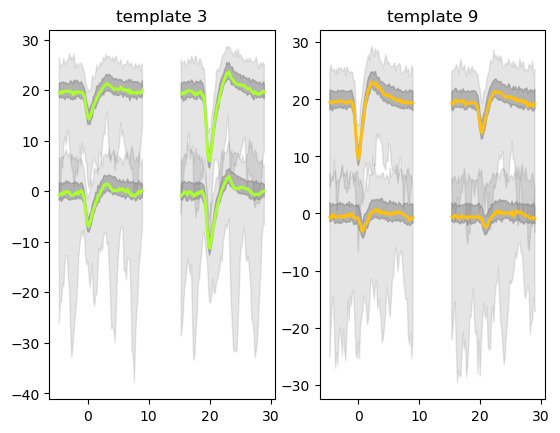

In [59]:
model, model_info = sc.load_model(
    model_folder=model_folder,
    trusted=['numpy.dtype'] # Specify which modules are trusted
)

labels_and_probababilities = si.auto_label_units(
    sorting_analyzer=analyzer,
    model_folder=model_folder,
    trust_model=True
)

""" 
# We can load a pretrained model from HuggingFace instead of training one
model, model_info = sc.load_model(
    sorting_analyzer = analyzer,
    repo_id = "SpikeInterface/toy_tetrode_model",
    trusted = ['numpy.dtype']
)


# The returned labels and probabilities are stored in the sorting analyzer
labels = analyzer.sorting.get_property("classifier_label")
probabilities = analyzer.sorting.get_property("classifier_probability")
"""

print(labels_and_probababilities)

sw.plot_unit_templates(analyzer, unit_ids=['3','9'])


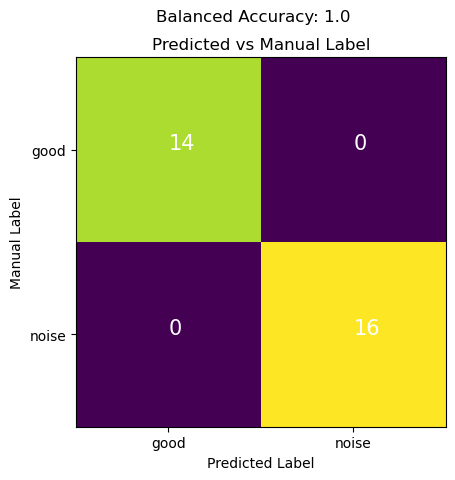

In [60]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

label_conversion = model_info['label_conversion']
predictions = labels_and_probababilities['prediction']

conf_matrix = confusion_matrix(manual_labels, predictions)

# Calculate balanced accuracy for the confusion matrix
balanced_accuracy = balanced_accuracy_score(manual_labels, predictions)

plt.imshow(conf_matrix)
for (index, value) in np.ndenumerate(conf_matrix):
    plt.annotate( str(value), xy=index, color="white", fontsize="15")
plt.xlabel('Predicted Label')
plt.ylabel('Manual Label')
plt.xticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.yticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.title('Predicted vs Manual Label')
plt.suptitle(f"Balanced Accuracy: {balanced_accuracy}")
plt.show()

#### Apply Model

In [ ]:
const = 1

"""
model, model_info = sc.load_model(
    repo_id = "SpikeInterface/UnitRefine_noise_neural_classifier",
    trusted = ['numpy.dtype']
)
"""


#for stream_id in tqdm(stream_ids):
for i in range(10):
    """
    h5 = h5py.File(path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(path, stream_id=stream_id, rec_name=rec_name)

    path_to_sorting = Path(save_root) / stream_id / 'sorter_output'
    sorting = si.read_kilosort(folder_path=path_to_sorting)
    """

    rec, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=const, num_units=5)
    _, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=const+1, num_units=5)
    const += 2

    sorting = si.aggregate_units([sorting_1, sorting_2])

    analyzer = si.create_sorting_analyzer(sorting=sorting, recording=rec)
    analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components', 'quality_metrics', 'template_metrics'])

    all_metric_names = list(analyzer.get_extension('quality_metrics').get_data().keys()) + list(analyzer.get_extension('template_metrics').get_data().keys())
    print(set(model.feature_names_in_).issubset(set(all_metric_names)))

    labels_and_probababilities = si.auto_label_units(
        sorting_analyzer=analyzer,
        model_folder=model_folder,
        #repo_id="SpikeInterface/UnitRefine_noise_neural_classifier",
        trust_model=True
    )

    print(labels_and_probababilities)

    #labels_and_probababilities = pd.DataFrame(labels_and_probababilities)
    #labels_and_probababilities.to_csv(path_to_sorting / 'labels_and_probabilities.csv')

estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     0.970000
1       good     0.940000
2       good     1.000000
3       good     0.970000
4       good     1.000000
5      noise     0.902973
6      noise     0.847556
7      noise     0.872140
8      noise     0.832140
9      noise     0.862140


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     1.000000
1      noise     0.562973
2       good     1.000000
3       good     1.000000
4       good     0.907860
5      noise     0.892140
6      noise     0.872973
7      noise     0.892973
8      noise     0.862973
9      noise     0.862140


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     1.000000
1       good     1.000000
2       good     0.897860
3      noise     0.782973
4       good     0.907860
5      noise     0.892973
6      noise     0.892973
7      noise     0.882140
8      noise     0.892973
9      noise     0.802973


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     1.000000
1       good     0.917860
2       good     0.980000
3       good     1.000000
4       good     0.907860
5      noise     0.882973
6      noise     0.882973
7      noise     0.862140
8      noise     0.862140
9      noise     0.882973


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     1.000000
1       good     0.597860
2       good     0.960000
3       good     1.000000
4       good     0.967860
5      noise     0.942973
6      noise     0.922973
7      noise     0.852973
8      noise     0.802973
9      noise     0.922140


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0      noise     0.822140
1       good     0.577860
2       good     0.617860
3       good     1.000000
4       good     1.000000
5      noise     0.892973
6      noise     0.882140
7      noise     0.872140
8      noise     0.852140
9      noise     0.872140


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     0.970000
1       good     1.000000
2       good     1.000000
3       good     0.927860
4       good     0.970000
5      noise     0.932973
6      noise     0.922140
7      noise     0.802140
8      noise     0.922140
9      noise     0.922973


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     1.000000
1      noise     0.892973
2       good     1.000000
3      noise     0.852140
4       good     1.000000
5      noise     0.742973
6      noise     0.952973
7      noise     0.892973
8      noise     0.742973
9      noise     0.852140


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0       good     0.927860
1       good     1.000000
2       good     1.000000
3       good     1.000000
4      noise     0.762140
5      noise     0.922140
6      noise     0.922140
7      noise     0.932973
8      noise     0.872140
9      noise     0.762973


estimate_sparsity (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

True
  prediction  probability
0      noise     0.872973
1       good     1.000000
2       good     0.970000
3       good     0.897860
4       good     0.980000
5      noise     0.882140
6      noise     0.892973
7      noise     0.882140
8      noise     0.882140
9      noise     0.862973
